# YouTube trending videos

In [208]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, silhouette_score

from helpers.categories import get_categories_dict
from helpers.files import load_csv

## Etap 4 - Wykorzystanie uczenia pół-nadzorowanego

# TODO normalizacja danych

### Wyczytanie danych

In [209]:
gb_data, us_data = load_csv("clustering_data")

videos = pd.concat([gb_data, us_data])
categories_ids = videos["new_category_id"].dropna().unique().tolist()

### Wczytanie nazw kategorii

In [210]:
categories_dict = get_categories_dict()
categories = [categories_dict[cat] for cat in categories_ids]

## Usunięcie danych tekstowych

In [211]:
videos = videos[videos["new_category_id"].notna()]
y_hat = videos["new_category_id"]  # oczekiwane kategorie z api
y_hat_nans = videos["category_id"]  # oczekiwane kategorie z nanami (z oryginalnego zbioru)
videos_no_nan_categories = videos[videos["category_id"].notna()]
selected_columns = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day",
    "gray_mean_score", "color_mean_score", "gray_hist_score",
    "red_hist_score", "green_hist_score", "blue_hist_score", "edges_score", "entropy_score",
]

for cat in categories_ids:
    selected_columns.append(f"freq_channel_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_tags_{categories_dict[cat]}")
    selected_columns.append(f"freq_descriptions_{categories_dict[cat]}")

videos = videos[selected_columns]
videos = videos.fillna(videos.mean())
x_not_nan = videos[y_hat_nans.notna()]
y_not_nan = y_hat_nans[y_hat_nans.notna()]

videos_no_nan_categories

,views,likes,dislikes,comment_count,description_len,title_len,channel_title_len,publish_time_day_of_week,publish_time_hour_of_day,gray_mean_score,...,freq_tags_Autos & Vehicles,freq_descriptions_Autos & Vehicles,freq_channel_titles_Travel & Events,freq_titles_Travel & Events,freq_tags_Travel & Events,freq_descriptions_Travel & Events,freq_channel_titles_Nonprofits & Activism,freq_titles_Nonprofits & Activism,freq_tags_Nonprofits & Activism,freq_descriptions_Nonprofits & Activism
0,28725,253,3,12,31.0,31,12,0,17,NaN,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00
4,1770509,163869,2704,7269,751.0,44,11,2,22,1027255.0,...,0.0,0.20,0.0,0.00,0.0,0.15,0.0,0.0,0.0,0.05
5,4651793,251125,1013,12150,331.0,33,6,1,12,642414.0,...,0.0,0.00,0.0,0.00,0.0,0.05,0.0,0.0,0.0,0.00
8,131985,5051,122,504,3405.0,67,9,6,18,750510.0,...,0.0,0.25,0.0,0.05,0.0,0.30,0.0,0.0,0.0,0.10
9,3592011,52578,2414,4919,527.0,40,18,3,8,1072894.0,...,0.0,0.10,0.0,0.05,0.0,0.05,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6322,3321250,66486,2417,4602,389.0,90,9,2,22,1274921.0,...,0.0,0.15,0.0,0.00,0.0,0.15,0.0,0.0,0.0,0.00
6333,261520,19333,124,735,1807.0,34,15,3,16,1411212.0,...,0.0,0.35,0.0,0.00,0.0,0.20,0.0,0.0,0.0,0.20
6339,656819,11856,433,1630,202.0,32,12,5,15,NaN,...,0.0,0.05,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.05
6341,52513,1278,56,432,494.0,63,18,2,20,1093469.0,...,0.0,0.30,0.0,0.00,0.0,0.15,0.0,0.0,0.0,0.05


### Uzupełnienie wartości pustych wartościami średnimi


In [212]:
# videos = videos.fillna(videos.mean())

### K-means

Dobre acc (przypisuje wszyskim jedną klasę ale słaba reszta metryk)
można zastosować bo znamy liczbę klas, do których będziemy przypisywać.

(8735, 5)


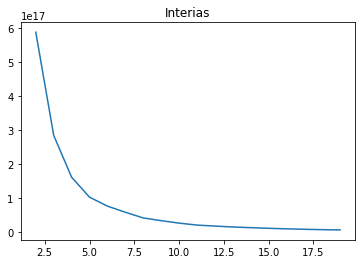

Catlen: 15
[10 10  0 ... 10 10  7]
    index  count
0    10.0    634
1    24.0    621
2    22.0    219
3    26.0    216
4    23.0    194
5    17.0    176
6     1.0    167
7    25.0    142
8    28.0    101
9    20.0     90
10   27.0     80
11   15.0     53
12   19.0     20
13    2.0     13
14   29.0      5
15   43.0      2
Index: RangeIndex(start=0, stop=16, step=1)
10.0
y   y_hat_nans
0   1.0            51
    2.0             1
    10.0          147
    15.0            4
    17.0           25
                 ... 
10  43.0            2
11  10.0            2
12  10.0            8
13  10.0           13
14  10.0            2
Name: c, Length: 78, dtype: int64
y   y_hat_nans
0   24.0          151
1   10.0            1
2   10.0           15
3   10.0            1
4   10.0           49
5   10.0           11
7   10.0          100
8   10.0           20
9   10.0           44
10  24.0          391
11  10.0            2
12  10.0            8
13  10.0           13
14  10.0            2
Name: c, dtyp

c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


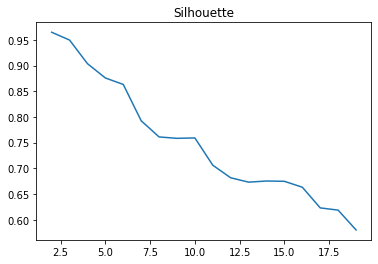

In [213]:
select = SelectKBest(chi2, k=5)
select.fit(x_not_nan, y_not_nan)
x = select.transform(videos)
print(x.shape)

k_list = np.arange(2, 20)
inertias = np.zeros_like(k_list, dtype=np.float)
silhouettes = np.zeros_like(k_list, dtype=np.float)
for i, k in enumerate(k_list):
    model = KMeans(k)
    # model.fit(x)
    labels = model.fit_predict(x)
    inertias[i] = model.inertia_
    silhouettes[i] = silhouette_score(x, labels)

plt.plot(k_list, inertias)
plt.title("Interias")
plt.show()
plt.plot(k_list, silhouettes)
plt.title("Silhouette")
print(f"Catlen: {len(categories)}")
model = KMeans(len(categories))
model.fit(x)
y = model.predict(x)
print(y)
def get_mapping_dict(y_hat_nans, y_pred) -> dict:
    values_counts = y_hat_nans.value_counts().reset_index(name="count")
    print(values_counts)
    print(f"Index: {values_counts.index}")
    most_frequent_class = values_counts["index"].iloc[0]
    print(most_frequent_class)
    mapping_dict = {}
    y_data = pd.DataFrame()
    y_data["y_hat_nans"] = y_hat_nans
    y_data["y"] = y_pred
    y_data["c"] = 1
    y_data = y_data.groupby(["y", "y_hat_nans"])["c"].sum()  #.max(level=[0])#.sort_values().groupby(level=0)
    print(y_data)
    out = y_data.loc[y_data.groupby(level=0).idxmax()]
    print(out)
    for row in out.index:
        mapping_dict[row[0]] = row[1]
    for i in range(len(categories)):
        if i not in mapping_dict.keys():
            mapping_dict[i] = most_frequent_class
    return mapping_dict


mapping_dict = get_mapping_dict(y_hat_nans, y)
print(mapping_dict)
y_mapped = pd.Series(y).apply(lambda x: mapping_dict[x])
print(f"Accuracy: {accuracy_score(y_hat, y_mapped)}")
print(f"F1: {f1_score(y_hat, y_mapped, average='macro')}")
print(f"Precision: {precision_score(y_hat, y_mapped, average='macro')}")

AHC - bo mamy zdefiniowaną liczbę grup?

In [214]:
model = AgglomerativeClustering(len(categories), compute_full_tree=True)
# model = DBSCAN(eps=0.6, min_samples=5)
model.fit(x)
y = model.labels_
print(np.unique(y))
mapping_dict = get_mapping_dict(y_hat_nans, y)
print(mapping_dict)
y_mapped = pd.Series(y).apply(lambda x: mapping_dict[x])
print(f"Accuracy: {accuracy_score(y_hat, y_mapped)}")
print(f"F1: {f1_score(y_hat, y_mapped, average='macro')}")
print(f"Precision: {precision_score(y_hat, y_mapped, average='macro')}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    index  count
0    10.0    634
1    24.0    621
2    22.0    219
3    26.0    216
4    23.0    194
5    17.0    176
6     1.0    167
7    25.0    142
8    28.0    101
9    20.0     90
10   27.0     80
11   15.0     53
12   19.0     20
13    2.0     13
14   29.0      5
15   43.0      2
Index: RangeIndex(start=0, stop=16, step=1)
10.0
y   y_hat_nans
0   10.0            9
1   1.0           120
    2.0            11
    10.0          279
    15.0           48
                 ... 
14  1.0             1
    10.0            9
    22.0            1
    24.0            4
    26.0            1
Name: c, Length: 77, dtype: int64
y   y_hat_nans
0   10.0            9
1   24.0          466
2   10.0          140
3   10.0           25
5   10.0           11
6   10.0           36
7   10.0            2
8   10.0           14
9   10.0           13
10  10.0            1
11  10.0           58
12  10.0            2
13  10.0           35
14  10.0            9
N

c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DBSCAN - bo mamy grupy różnej wielkości ?

In [217]:
model = DBSCAN(eps=0, min_samples=5)
model.fit(x)
y = model.labels_
print(np.unique(y))
mapping_dict = get_mapping_dict(y_hat_nans, y)
print(mapping_dict)
y_mapped = pd.Series(y).apply(lambda x: mapping_dict[x])
print(f"Accuracy: {accuracy_score(y_hat, y_mapped)}")
print(f"F1: {f1_score(y_hat, y_mapped, average='macro')}")
print(f"Precision: {precision_score(y_hat, y_mapped, average='macro')}")

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
    index  count
0    10.0    634
1    24.0    621
2    22.0    219
3    26.0    216
4    23.0    194
5    17.0    176
6     1.0    167
7    25.0    142
8    28.0    101
9    20.0     90
10   27.0     80
11   15.0     53
12   19.0     20
13    2.0     13
14   29.0      5
15   43.0      2
Index: RangeIndex(start=0, stop=16, step=1)
10.0
y    y_hat_nans
-1   1.0           164
     2.0            12
     10.0          632
     15.0           50
     17.0          168
     19.0           20
     20.0           89
     22.0          210
     23.0          191
     24.0          613
     25.0          132
     26.0          215
     27.0           79
     28.0          100
     29.0            5
     43.0            1
 0   22.0            3
     24.0            1
 1   15.0            1
     17.0            3
 2   1.0             1
     17.0            3
     20.0            1
     22.0            3
     23.0            1
     24.0   

KeyError: 16